In [1]:
!pip install --user tf-agents

     |████████████████████████████████| 1.1 MB 582 kB/s 
     |████████████████████████████████| 44 kB 1.3 MB/s 


In [2]:
import tensorflow as tf
import numpy as np
from tf_agents.environments import py_environment, tf_environment, tf_py_environment, utils, wrappers, suite_gym
from tf_agents.specs import array_spec
from tf_agents.trajectories import trajectory,time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics,  py_metrics
# from tf_agents import metric_utils
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.drivers import py_driver, dynamic_episode_driver
from tf_agents.utils import common

import matplotlib.pyplot as plt


# Functions

In [3]:
class GridWorldEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(4,), dtype=np.int32, minimum=[0,0,0,0],maximum=[5,5,5,5], name='observation')
        self._state=[0,0,5,5] #represent the (row, col, frow, fcol) of the player and the finish
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state=[0,0,5,5]
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.int32))

    def _step(self, action):

        if self._episode_ended:
            return self.reset()

        self.move(action)

        if self.game_over():
            self._episode_ended = True

        if self._episode_ended:
            if self.game_over():
                reward = 100
            else:
                reward = 0
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            return ts.transition(
                np.array(self._state, dtype=np.int32), reward=0, discount=0.9)

    def move(self, action):
        row, col, frow, fcol = self._state[0],self._state[1],self._state[2],self._state[3]
        if action == 0: #down
            if row - 1 >= 0:
                self._state[0] -= 1
        if action == 1: #up
            if row + 1 < 6:
                self._state[0] += 1
        if action == 2: #left
            if col - 1 >= 0:
                self._state[1] -= 1
        if action == 3: #right
            if col + 1  < 6:
                self._state[1] += 1

    def game_over(self):
        row, col, frow, fcol = self._state[0],self._state[1],self._state[2],self._state[3]
        return row==frow and col==fcol



In [4]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [5]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

# Model

In [6]:
# parameter settings

num_iterations = 10000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 128  # @param
learning_rate = 1e-5  # @param
log_interval = 200  # @param

num_eval_episodes = 2  # @param
eval_interval = 1000  # @param

In [7]:
train_py_env = wrappers.TimeLimit(GridWorldEnv(), duration=100)
eval_py_env = wrappers.TimeLimit(GridWorldEnv(), duration=100)



In [8]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [9]:
q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)


train_step_counter = tf.compat.v2.Variable(0)



In [10]:

tf_agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn = common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

tf_agent.initialize()


In [11]:

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy


In [12]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_capacity)

print("Batch Size: {}".format(train_env.batch_size))

replay_observer = [replay_buffer.add_batch]

train_metrics = [
            tf_metrics.NumberOfEpisodes(),
            tf_metrics.EnvironmentSteps(),
            tf_metrics.AverageReturnMetric(),
            tf_metrics.AverageEpisodeLengthMetric(),
]


Batch Size: 1


In [13]:
dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

In [14]:
driver = dynamic_step_driver.DynamicStepDriver(
            train_env,
            collect_policy,
            observers=replay_observer + train_metrics,
    num_steps=1)

iterator = iter(dataset)

In [15]:
print(compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes))

tf_agent.train = common.function(tf_agent.train)
tf_agent.train_step_counter.assign(0)

final_time_step, policy_state = driver.run()

for i in range(1000):
    final_time_step, _ = driver.run(final_time_step, policy_state)


0.0


In [16]:
episode_len = []
step_len = []
for i in range(num_iterations):
    final_time_step, _ = driver.run(final_time_step, policy_state)

    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience=experience)
    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))
        episode_len.append(train_metrics[3].result().numpy())
        step_len.append(step)
        print('Average episode length: {}'.format(train_metrics[3].result().numpy()))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))

step = 200: loss = 0.27092617750167847
Average episode length: 96.5999984741211
step = 400: loss = 0.08925052732229233
Average episode length: 96.5999984741211
step = 600: loss = 0.04888586699962616
Average episode length: 96.5999984741211
step = 800: loss = 0.04527277499437332
Average episode length: 96.5999984741211
step = 1000: loss = 0.04451741278171539
Average episode length: 97.5999984741211
step = 1000: Average Return = 0.0
step = 1200: loss = 0.02019939199090004
Average episode length: 97.5999984741211
step = 1400: loss = 0.02462056837975979
Average episode length: 97.5999984741211
step = 1600: loss = 0.013112186454236507
Average episode length: 97.5999984741211
step = 1800: loss = 0.004257255233824253
Average episode length: 97.5999984741211
step = 2000: loss = 78.85380554199219
Average episode length: 100.0
step = 2000: Average Return = 0.0
step = 2200: loss = 0.010012316517531872
Average episode length: 100.0
step = 2400: loss = 0.009675763547420502
Average episode length: 1

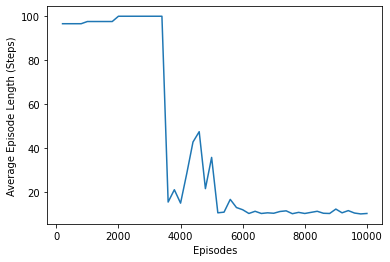

In [17]:
plt.plot(step_len, episode_len)
plt.xlabel('Episodes')
plt.ylabel('Average Episode Length (Steps)')
plt.show()